In [50]:
import GamificationRL
from collections import defaultdict
import gymnasium as gym
from GamificationRL.envs.gamification_elements import *
import random
from itertools import permutations  
from adaptive_agent import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from hexad_answer_bot import *
plt.rcParams["figure.figsize"]=(10,7)
import pandas as pd
hexad_types_full = ["Player", "Achiever", "Philanthropist", "Disruptor", "Socializer", "Free Spirit"]
import logging
gym.logger.setLevel(logging.CRITICAL)

#### Environment Init

In [51]:
corr_g_e=list(corr_gamification_elements.values())
sample_g_e=list(sample_gamification_elements.values())
g_e=sample_g_e[1::2]
colors=['violet','purple','red','sienna',
        'darkorange','burlywood','gold','darkgoldenrod',
        'olivedrab','lawngreen','deepskyblue','steelblue']
ge2c={"Nothing":'black'}
for i in range(len(g_e)):
    ge2c[g_e[i].name]=colors[i]
#hexad=hexad_load_dict(pl=2,ach=5,ph=4,dis=0.5,s=1,fs=3).load_dict
hexad=hexad_load_dict(pl=3,ach=3,ph=3,dis=3,s=3,fs=3).load_dict
fatigue_penalty=0.05
fatigue_replenishment=0.01
nothing_reward=75
rrange=(1.0,1.3,1.7)
increase=(0.2,0.1,0.05)
decrease=(0.1,0.1,0.1)
pref_min=0.2
seed=10101

In [52]:
env = gym.make('GamificationRL/GamificationPreferenceEnv-v0',
               hexad_load=hexad,
               gamification_elements=g_e,
               use_fatigue=True,
               individual_modifications=None,
               repetition_penalty=(400,800),
               nothing_reward=nothing_reward,
               fatigue_reduction=fatigue_penalty,
               fatigue_replenish=fatigue_replenishment,
               pref_ranges=rrange,
               pref_increase=increase,
               pref_decrease=decrease,
               pref_min=pref_min,
               seed=seed
               )
obs,_=env.reset()

#### Answer Bot Init

In [53]:
uncertainty=.1
divisor=5.5
starting_threshold=.1
gain_modifier=0.02
amount=1
#ht=copy.deepcopy(hexad)
ht=hexad_load_dict(pl=2,ach=5,ph=4,dis=0.5,s=1,fs=3).load_dict

In [54]:
bot = ScoreChangeBot(
        hexad_types=copy.deepcopy(ht),
        uncertainty=uncertainty,
        divisor=divisor,
        starting_change_threshold=starting_threshold,
        change_gain_modifier=gain_modifier,
        change_amount=amount,
        seed=seed,
    )

#### Agent init

In [55]:
#general parameters
learn_rate=0.002
discount_factor=0.7

In [56]:
#Fatigue-aware parameters
epsilon=1
epsilon_min=0.1
#training_iterations=int(1e6)
training_iterations=int(1e5)
epsilon_decay=(epsilon-epsilon_min)/(training_iterations*3/4000)

In [57]:
fa_agent=FatigueAwareAgent(learn_rate=learn_rate,
                   discount_factor=discount_factor,
                   env=env,
                   epsilon=epsilon,
                   epsilon_decay=epsilon_decay,
                   epsilon_min=epsilon_min,
                   )
train_error=fa_agent.train(env=env,iterations=training_iterations,trunc_error=True)

In [58]:
#Epsilon agent parameters
epsilon=1
epsilon_min=0.1
#training_iterations=int(1e6)
training_iterations=int(1e5)
epsilon_decay=(epsilon-epsilon_min)/(training_iterations*3/4000)

In [59]:
e_agent=EpsilonAGAgent(learn_rate=learn_rate,
                   discount_factor=discount_factor,
                   env=env,
                   epsilon=epsilon,
                   epsilon_decay=epsilon_decay,
                   epsilon_min=epsilon_min,
                   )
train_error=e_agent.train(env=env,iterations=training_iterations,trunc_error=True)

In [60]:

basic_agent=BasicAGAgent(learn_rate=learn_rate,
                   discount_factor=discount_factor,
                   env=env,
                   )
train_error=basic_agent.train(env=env,iterations=training_iterations,trunc_error=True)


In [61]:
#RandomBestOfX parameters
epsilon=1
epsilon_min=0.1
#training_iterations=int(1e6)
training_iterations=int(1e5)
epsilon_decay=(epsilon-epsilon_min)/(training_iterations*4/5000)
x=3

In [62]:

boX_agent=RandomBestOfX(learn_rate=learn_rate,
                   discount_factor=discount_factor,
                   env=env,
                   epsilon=epsilon,
                   epsilon_decay=epsilon_decay,
                   epsilon_min=epsilon_min,
                   X=x
                   )

train_error=boX_agent.train(env=env,iterations=training_iterations,trunc_error=True)


In [63]:
agents={"Basic":basic_agent,"Epsilon":e_agent,"BestOfX":boX_agent,"FatigueAware":fa_agent}
init_q_values={}
for name,agent in agents.items():
    init_q_values[name]=copy.deepcopy(agent.q_values)

#### Testing Functions

In [64]:
def test_env_agent(env,agent,answer_bot,test_iterations,retrain_iterations,random_retrain,training_lr):
    rewards=[]
    choices=[]
    best=[]
    agent_error=[]
    actions=defaultdict(lambda:{'x':[],'y':[]})
    hexad_diff=[]
    hd_stats={'mean':[],'std':[]}
    obs,info=env.reset()
    for i in tqdm(range(test_iterations)):
        best.append(env.get_best_action())
        act=agent.get_action(obs,avoid_reps=True)
        h_type=env.ge[env.action_to_ge[act]].type
        answer,_=answer_bot.get_answer(h_type)
        choice,reward,new_obs,info,error=agent\
            .step_and_update(env=env,
                            obs=obs,
                            answer=answer,
                            retrain_iterations=retrain_iterations,
                            learning_rate=training_lr,
                            random_retrain=random_retrain,
                            act=act)
        choices.append(choice)
        rewards.append(reward)
        agent_error.append(error)
        actions[choice]['x'].append(i)
        actions[choice]['y'].append(reward)
        diff=0
        d_s=[]
        for typ,val in answer_bot.hexad_profile.items():
            v=abs(val-env.hexad_adjusted[typ])
            diff+=v
            d_s.append(v)
        hd_stats['mean'].append(np.mean(d_s))
        hd_stats['std'].append(np.std(d_s))
        hexad_diff.append(diff)
        obs=new_obs
    return rewards,choices,best,agent_error,actions,(obs,info),hexad_diff,hd_stats

In [65]:
def plot_actions(actions,env,title=None,f=1):
    typ='pl'
    fig=plt.figure(f,figsize=(12,7))
    fig.suptitle(title)
    for i,_ in sorted(actions.items()):
        name=env.action_to_ge[i]
        hex_type=env.ge[name].type
        if hex_type!=None:
            plt.figure(f)
            type_index=hexad_types.index(env.ge[name].type)+1
        else:
            plt.figure(f+1)
        plt.subplot(3,2,type_index)
        plt.ylim(0,1000)
        plt.xlim(0,1000)
        plt.scatter(actions[i]['x'],actions[i]['y'],label=name,s=2)
        ax=plt.gca()
        ax.legend()
    plt.figure(f+2)
    fig.suptitle(title)
    for i in actions:
        plt.scatter(actions[i]['x'],actions[i]['y'],label=env.action_to_ge[i],s=5)
        ax=plt.gca()
        ax.legend()

In [66]:
def get_stats(actions,best,choices):
    type_stats=defaultdict(lambda:0)
    for i in actions:
        try:
            type_stats[sample_gamification_elements[env.action_to_ge[i]].type]+=len(actions[i]['x'])
        except KeyError:
            type_stats['None']+=len(actions[i]['x'])
    s=0
    for i in range(len(best)):
        if best[i][1]==choices[i][1]:
            s+=1
    diff=[best[i][1]-choices[i][1] for i in range(len(choices))]
    diff=np.array(diff)
    diff=diff[diff>0.01]
    actual=pd.Series([env.action_to_ge[item[0]] for item in best],name="Actual Best")
    pred = pd.Series([env.action_to_ge[item[0]] for item in b],name="Predicted Best")
    conf_matrix=pd.crosstab(actual,pred,margins=True)
    return type_stats,s/len(best),diff,conf_matrix

#### Hyperparameter tuning

##### Hexad Preference range

In [72]:
rrange=(1.0,1.3,1.7)
increase=(0.2,0.1,0.05)
decrease=(0.1,0.1,0.1)

ranges = [ (0.8,1.2,1.7) ,(0.8,1.2,1.7) ,(0.61,0.71,1.28,1.38,1.58,1.68), (1.7,)]
increases=[(0.2,0.1,0.05),(0.05,0.2,0.05) ,(0.1,0.025,0.1,0.025,0.1,0.025),(0.1,)]
decreases=[(0.1,0.1,0.1) ,(0.05,0.2,0.05) ,(0.1,0.025,0.1,0.025,0.1,0.025),(0.1,)]
test_range=[*zip(ranges,increases,decreases)]
for a,b,c in test_range:
    print(len(a),len(b),len(c))

3 3 3
3 3 3
6 6 6
1 1 1


In [74]:
tests=500
retrains=2000
retrain_learn_rate=0.3
accs={}
a_e={}
d_b={}
hexad_diff={}
j=0
for name,agent in agents.items():
    print(name)
    random_retrain=(name=="Basic" or name=='BestOfX')
    accs[name]={'avg':[],'std':[]}
    a_e[name]={'avg':[],'std':[]}
    d_b[name]={'avg':[],'std':[]}
    hexad_diff[name]={'avg':[],'std':[]}
    for rrange,increase,decrease in tqdm(test_range):
        print(f"Current test: {rrange}")
        print("Iteration: ",end='')
        accuracy=[]
        diff_from_best=[]
        agent_error=[]
        abs_hex_diff=[]
        for j in range(4):
            env = gym.make('GamificationRL/GamificationPreferenceEnv-v0',
               hexad_load=hexad,
               gamification_elements=g_e,
               use_fatigue=True,
               individual_modifications=None,
               repetition_penalty=(400,800),
               nothing_reward=nothing_reward,
               fatigue_reduction=fatigue_penalty,
               fatigue_replenish=fatigue_replenishment,
               pref_ranges=rrange,
               pref_increase=increase,
               pref_decrease=decrease,
               pref_min=pref_min,
               seed=seed
               )
            obs,_=env.reset()
            agent.reset()
            agent.train(env=env,iterations=training_iterations,trunc_error=True)
            obs,_=env.reset()
            print(f"{j+1}, ",end='')
            r,c,b,e,a,_,hd,hd_stats=test_env_agent(env,agent,
                        answer_bot=bot,
                        test_iterations=tests,
                        retrain_iterations=retrains,
                        random_retrain=random_retrain,
                        training_lr=retrain_learn_rate)
            t,acc,diff,conf_matrix = get_stats(a,b,[*zip(c,r)])
            accuracy.append(acc)
            diff_from_best.extend((diff))
            agent_error.extend((e))
            abs_hex_diff.extend(hd)
            bot = ScoreChangeBot(
                hexad_types=ht,
                uncertainty= uncertainty,
                divisor=divisor,
                starting_change_threshold=starting_threshold,
                change_gain_modifier=gain_modifier,
                change_amount=amount,
                seed=seed,
            )
        print()  
        hexad_diff[name]['avg'].append(np.average(abs_hex_diff))
        hexad_diff[name]['std'].append(np.std(abs_hex_diff))
        accs[name]['avg'].append(np.average(accuracy))
        accs[name]['std'].append(np.std(accuracy))
        a_e[name]['avg'].append(np.average(agent_error))
        a_e[name]['std'].append(np.std(agent_error))
        d_b[name]['avg'].append(np.average(diff_from_best))
        d_b[name]['std'].append(np.std(diff_from_best))

Basic


  0%|          | 0/4 [00:00<?, ?it/s]

Current test: (0.8, 1.2, 1.7)
Iteration: 1, 

100%|██████████| 500/500 [00:12<00:00, 41.50it/s]


2, 

100%|██████████| 500/500 [00:28<00:00, 17.72it/s]


3, 

100%|██████████| 500/500 [00:47<00:00, 10.48it/s]


4, 

 25%|██▌       | 1/4 [02:27<07:22, 147.59s/it]


Current test: (0.8, 1.2, 1.7)
Iteration: 1, 

100%|██████████| 500/500 [00:47<00:00, 10.62it/s]


2, 

100%|██████████| 500/500 [00:34<00:00, 14.51it/s]


3, 

100%|██████████| 500/500 [00:33<00:00, 15.07it/s]


4, 

 50%|█████     | 2/4 [05:24<05:29, 164.72s/it]


Current test: (0.61, 0.71, 1.28, 1.38, 1.58, 1.68)
Iteration: 1, 

100%|██████████| 500/500 [00:46<00:00, 10.67it/s]


2, 

100%|██████████| 500/500 [00:47<00:00, 10.55it/s]


3, 

100%|██████████| 500/500 [00:38<00:00, 12.99it/s]


4, 

 75%|███████▌  | 3/4 [08:04<02:42, 162.76s/it]


Current test: (1.7,)
Iteration: 1, 

100%|██████████| 500/500 [00:12<00:00, 40.57it/s]


2, 

100%|██████████| 500/500 [00:42<00:00, 11.74it/s]


3, 

100%|██████████| 500/500 [00:45<00:00, 11.00it/s]


4, 

100%|██████████| 4/4 [10:44<00:00, 161.20s/it]



Epsilon


  0%|          | 0/4 [00:00<?, ?it/s]

Current test: (0.8, 1.2, 1.7)
Iteration: 1, 

100%|██████████| 500/500 [00:58<00:00,  8.50it/s]


2, 

100%|██████████| 500/500 [00:58<00:00,  8.54it/s]


3, 

100%|██████████| 500/500 [00:58<00:00,  8.56it/s]


4, 

 25%|██▌       | 1/4 [04:15<12:47, 255.84s/it]


Current test: (0.8, 1.2, 1.7)
Iteration: 1, 

100%|██████████| 500/500 [00:58<00:00,  8.56it/s]


2, 

100%|██████████| 500/500 [00:59<00:00,  8.45it/s]


3, 

100%|██████████| 500/500 [00:18<00:00, 27.30it/s]


4, 

 50%|█████     | 2/4 [07:02<06:46, 203.18s/it]


Current test: (0.61, 0.71, 1.28, 1.38, 1.58, 1.68)
Iteration: 1, 

100%|██████████| 500/500 [00:14<00:00, 33.78it/s]


2, 

100%|██████████| 500/500 [00:15<00:00, 32.86it/s]


3, 

100%|██████████| 500/500 [00:15<00:00, 33.29it/s]


4, 

 75%|███████▌  | 3/4 [08:07<02:20, 140.17s/it]


Current test: (1.7,)
Iteration: 1, 

100%|██████████| 500/500 [00:14<00:00, 33.38it/s]


2, 

100%|██████████| 500/500 [00:14<00:00, 33.77it/s]


3, 

100%|██████████| 500/500 [00:15<00:00, 33.13it/s]


4, 

100%|██████████| 4/4 [09:12<00:00, 138.09s/it]



BestOfX


  0%|          | 0/4 [00:00<?, ?it/s]

Current test: (0.8, 1.2, 1.7)
Iteration: 1, 

100%|██████████| 500/500 [00:12<00:00, 38.97it/s]


2, 

100%|██████████| 500/500 [00:14<00:00, 34.98it/s]


3, 

100%|██████████| 500/500 [00:12<00:00, 39.45it/s]


4, 

 25%|██▌       | 1/4 [00:58<02:55, 58.64s/it]


Current test: (0.8, 1.2, 1.7)
Iteration: 1, 

100%|██████████| 500/500 [00:12<00:00, 39.61it/s]


2, 

100%|██████████| 500/500 [00:12<00:00, 38.86it/s]


3, 

100%|██████████| 500/500 [00:12<00:00, 39.53it/s]


4, 

 50%|█████     | 2/4 [01:55<01:55, 57.59s/it]


Current test: (0.61, 0.71, 1.28, 1.38, 1.58, 1.68)
Iteration: 1, 

100%|██████████| 500/500 [00:13<00:00, 36.05it/s]


2, 

100%|██████████| 500/500 [00:13<00:00, 36.21it/s]


3, 

100%|██████████| 500/500 [00:13<00:00, 36.96it/s]


4, 

 75%|███████▌  | 3/4 [02:55<00:58, 58.73s/it]


Current test: (1.7,)
Iteration: 1, 

100%|██████████| 500/500 [00:13<00:00, 36.77it/s]


2, 

100%|██████████| 500/500 [00:12<00:00, 38.71it/s]


3, 

100%|██████████| 500/500 [00:12<00:00, 38.73it/s]


4, 

100%|██████████| 4/4 [03:53<00:00, 58.40s/it]



FatigueAware


  0%|          | 0/4 [00:00<?, ?it/s]

Current test: (0.8, 1.2, 1.7)
Iteration: 1, 

100%|██████████| 500/500 [00:15<00:00, 31.63it/s]


2, 

100%|██████████| 500/500 [00:18<00:00, 27.00it/s]


3, 

100%|██████████| 500/500 [00:15<00:00, 31.46it/s]


4, 

 25%|██▌       | 1/4 [01:11<03:34, 71.44s/it]


Current test: (0.8, 1.2, 1.7)
Iteration: 1, 

100%|██████████| 500/500 [00:15<00:00, 32.15it/s]


2, 

100%|██████████| 500/500 [00:15<00:00, 31.70it/s]


3, 

100%|██████████| 500/500 [00:15<00:00, 31.34it/s]


4, 

 50%|█████     | 2/4 [02:20<02:19, 69.95s/it]


Current test: (0.61, 0.71, 1.28, 1.38, 1.58, 1.68)
Iteration: 1, 

100%|██████████| 500/500 [00:15<00:00, 32.02it/s]


2, 

100%|██████████| 500/500 [00:15<00:00, 32.20it/s]


3, 

100%|██████████| 500/500 [00:15<00:00, 31.99it/s]


4, 

 75%|███████▌  | 3/4 [03:28<01:09, 69.01s/it]


Current test: (1.7,)
Iteration: 1, 

100%|██████████| 500/500 [00:15<00:00, 31.82it/s]


2, 

100%|██████████| 500/500 [00:16<00:00, 31.15it/s]


3, 

100%|██████████| 500/500 [00:15<00:00, 31.80it/s]


4, 

100%|██████████| 4/4 [04:36<00:00, 69.23s/it]

In [76]:
hexad_diff

{'Basic': {'avg': [4.367849999999999, 8.049925, 6.5205375, 8.9429],
  'std': [1.8273632308602465,
   1.9912097439433651,
   2.2202668473842837,
   2.905449980639832]},
 'Epsilon': {'avg': [4.124024999999999,
   5.2296499999999995,
   6.9223225,
   8.515899999999998],
  'std': [1.6449161222916509,
   2.2084793133511575,
   1.886321246101456,
   2.35547175529659]},
 'BestOfX': {'avg': [4.349249999999999, 9.064675, 6.351487499999999, 9.28625],
  'std': [1.7650642870728535,
   1.823779974222494,
   2.2881819966610504,
   2.3650488234918114]},
 'FatigueAware': {'avg': [4.226599999999999,
   8.496975,
   6.3698999999999995,
   8.930200000000001],
  'std': [1.691447587127665,
   2.1024169661071044,
   2.13843552392865,
   2.8475178594698924]}}

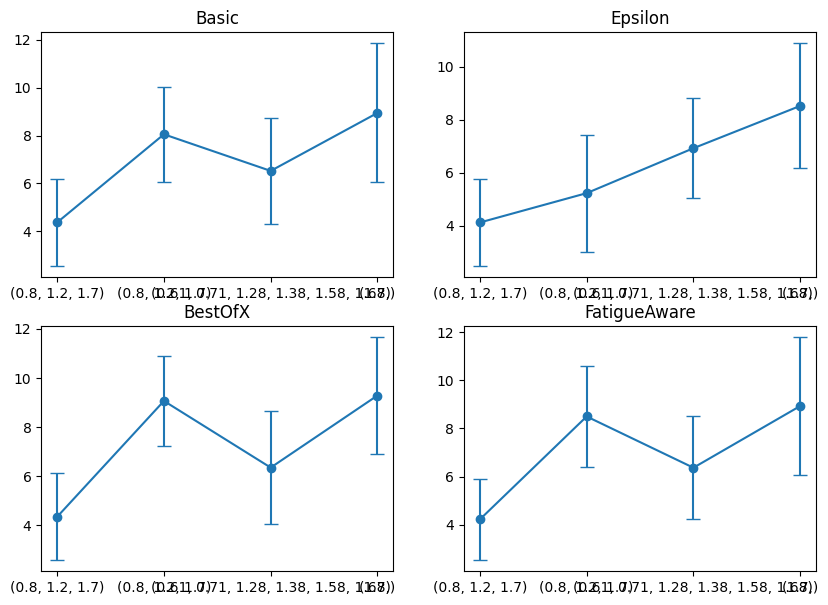

In [90]:
i=1
for name,agent in agents.items():
    ax=plt.subplot(2,2,i)
    plt.errorbar(range(len(ranges)),hexad_diff[name]['avg'],hexad_diff[name]['std'],marker='o',capsize=5)
    ax.set_xticks(range(len(ranges)),ranges,)
    plt.title(name)
    i+=1

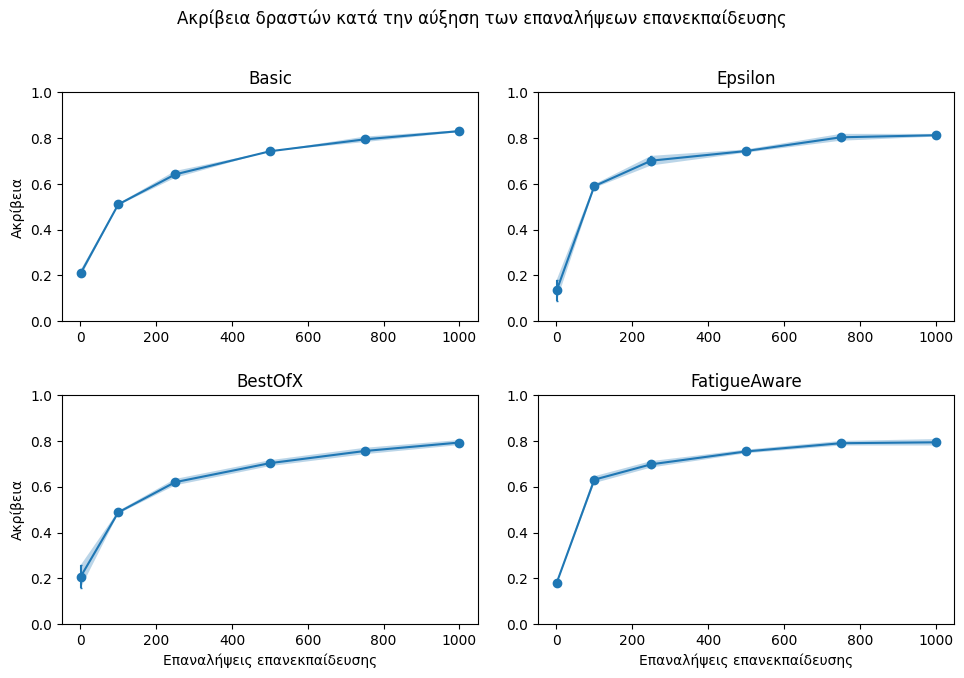

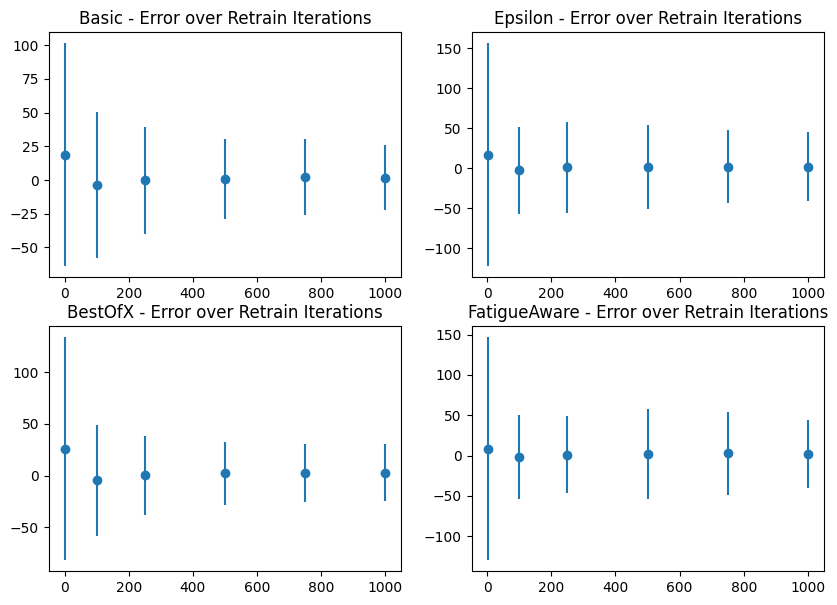

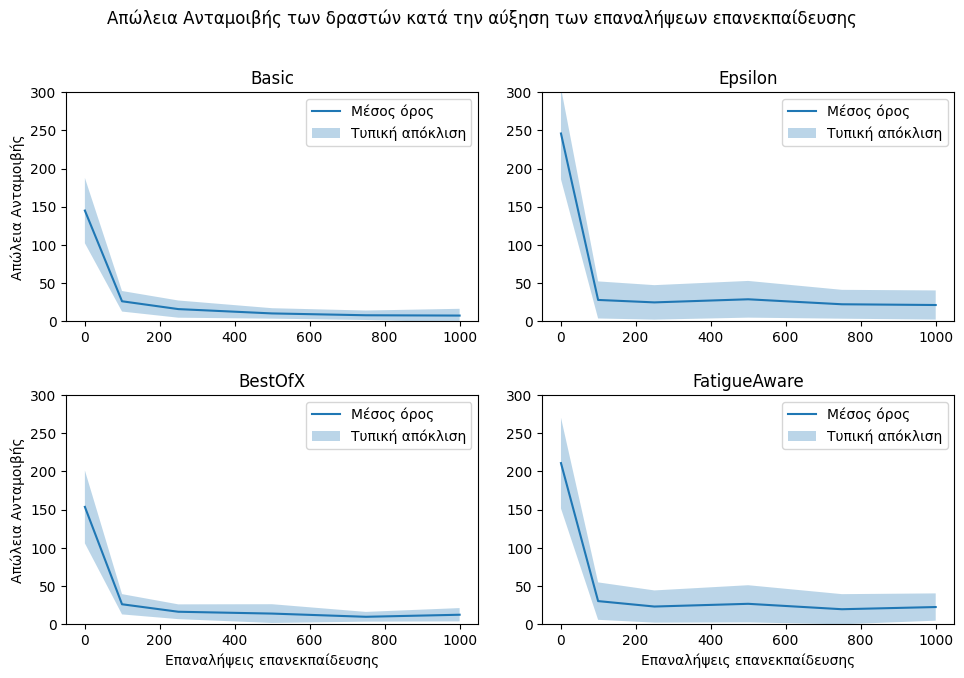

In [ ]:
i=1
for name,agent in agents.items():
    plt.figure(1)
    plt.subplot(2,2,i)
    plt.errorbar(test_range,accs[name]['avg'],accs[name]['std'],marker='o',capsize=1)
    plt.fill_between(test_range,np.array(accs[name]['avg'])-np.array(accs[name]['std']),np.array(accs[name]['avg'])+np.array(accs[name]['std']),alpha=0.3)
    plt.tight_layout(pad=2)
    plt.ylim(0,1)
    if i in [1,3]:
        plt.ylabel('Ακρίβεια')
    if i in [3,4]:
        plt.xlabel('Επαναλήψεις επανεκπαίδευσης')
    plt.title("{}".format(name))
    plt.suptitle("Ακρίβεια δραστών κατά την αύξηση των επαναλήψεων επανεκπαίδευσης")
    plt.figure(2)
    plt.subplot(2,2,i)
    plt.errorbar(test_range,a_e[name]['avg'],a_e[name]['std'],marker='o',linestyle='')
    plt.title("{} - Error over Retrain Iterations".format(name))
    plt.figure(3)
    plt.subplot(2,2,i)
    y=np.array(d_b[name]['avg'])
    y_error=np.array(d_b[name]['std'])
    plt.plot(test_range,y,label='Μέσος όρος')
    plt.fill_between(test_range,y-y_error/2,y+y_error/2,alpha=0.3,label='Τυπική απόκλιση')
    plt.legend()
    plt.title("{}".format(name))
    plt.tight_layout(pad=2)
    plt.ylim(0,300)
    if i in [1,3]:
        plt.ylabel('Απώλεια Ανταμοιβής')
    if i in [3,4]:
        plt.xlabel('Επαναλήψεις επανεκπαίδευσης')
    plt.suptitle("Απώλεια Ανταμοιβής των δραστών κατά την αύξηση των επαναλήψεων επανεκπαίδευσης")
    i+=1